In [1]:
import ee
# ee.Authenticate()
ee.Initialize(project='ee-pearsemurphy04')


In [31]:
import geemap
from geemap import geojson_to_ee
from ipyleaflet import GeoJSON
import geojson
from geojson import Feature, FeatureCollection, dump
from eo_utils import geojson_to_shapely
import shapely
from shapely import Polygon
import json
import numpy as np

In [3]:
def dump_poly(poly, outfile):
    features = []
    features.append(Feature(geometry=poly))
    feature_collection = FeatureCollection(features)
    with open(outfile, "w") as gj:
        dump(feature_collection, gj)
    return

In [213]:
def separate_park(roi_json, park_json, park_name):
    roi_poly = geojson_to_shapely(roi_json)
    park_poly = geojson_to_shapely(park_json)
    inside_park = roi_poly & park_poly
    outside_park = roi_poly ^ inside_park
    dump_poly(inside_park, f"/data/tapas/pearse/malawi/sentinel1/aoi/inside_{park_name}.geojson")
    dump_poly(outside_park, f"/data/tapas/pearse/malawi/sentinel1/aoi/outside_{park_name}.geojson")
    return inside_park, outside_park

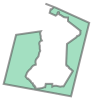

In [214]:
inside_kasungu, outside_kasungu = separate_park("/data/tapas/pearse/malawi/sentinel1/aoi/kasungu_small.geojson", "/data/tapas/pearse/malawi/sentinel1/aoi/kasungu_np.geojson", "kasungu")
inside_liwonde, outside_liwonde = separate_park("/data/tapas/pearse/malawi/sentinel1/aoi/southern_malawi_aoi.geojson", "/data/tapas/pearse/malawi/sentinel1/aoi/liwonde_np.geojson", "liwonde")
outside_liwonde

In [215]:
modis_col = ee.ImageCollection("MODIS/061/MOD09A1")
modis_vi_col = ee.ImageCollection("MODIS/061/MOD13A1")
countries = ee.FeatureCollection("FAO/GAUL/2015/level0")


Malawi = countries.filter(ee.Filter.eq('ADM0_NAME', 'Malawi'))
modis_im = modis_col.filterDate("2023-01-01", "2024-05-31").filterBounds(Malawi).sort("system:time_start", False).first()
modis_vi_im = modis_vi_col.filterDate("2023-01-01", "2024-05-31").filterBounds(Malawi).sort("system:time_start", False).first()
modis_vi_im = modis_vi_im.multiply(0.0001)

# gj_file = "/data/tapas/pearse/malawi/sentinel1/aoi/kasungu_small.geojson"
outside_file = "/data/tapas/pearse/malawi/sentinel1/aoi/outside_liwonde.geojson"
inside_file = "/data/tapas/pearse/malawi/sentinel1/aoi/inside_liwonde.geojson"
# with open(gj_file) as gj:
#     poly_coords = geojson.load(gj)

with open(outside_file) as tgj:
    outside_liwonde = geojson.load(tgj)
    
with open(inside_file) as tgj:
    inside_liwonde = geojson.load(tgj)

visParams = {"bands": ['sur_refl_b01', 'sur_refl_b04', 'sur_refl_b03'], "min":0, "max":3000}
Map = geemap.Map(zoom=5)
Map.centerObject(Malawi)
Map.addLayer(modis_im.clip(Malawi), visParams)
Map.addLayer(modis_vi_im.clip(Malawi), {"bands":"NDVI", "min":-0.5, "max":0.5, "palette":["blue", "white","forestgreen"]})
# json_layer = GeoJSON(
#     data=poly_coords,
#     name="liwonde ROI",
#     hover_style={"fillColor": "red", "fillOpacity": 0.5},
# )
# Map.add_layer(json_layer)
outside_liwonde_ee = geojson_to_ee(outside_liwonde)
inside_liwonde_ee = geojson_to_ee(inside_liwonde)
Map.addLayer(outside_liwonde_ee, {}, "liwonde EE")
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [72]:
outside_kasungu_ee.geometry()

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection",
          "arguments": {
            "features": {
              "arrayValue": {
                "values": [
                  {
                    "functionInvocationValue": {
                      "functionName": "Feature",
                      "arguments": {
                        "geometry": {
                          "functionInvocationValue": {
                            "functionName": "GeometryConstructors.Polygon",
                            "arguments": {
                              "coordinates": {
                                "constantValue": [
                                  [
                                    [
                                      33.55,
                                      -12.85
                                    ],
                                    [
                                      33.55,
                                      -13.12
                                    ],
                                    [
                                      33.246612,
                                      -13.12
                                    ],
                                    [
                                      33.245882,
                                      -13.117847
                                    ],
                                    [
                                      33.245902,
                                      -13.113995
                                    ],
                                    [
                                      33.246625,
                                      -13.110666
                                    ],
                                    [
                                      33.246874,
                                      -13.108017
                                    ],
                                    [
                                      33.247302,
                                      -13.104797
                                    ],
                                    [
                                      33.245317,
                                      -13.103063
                                    ],
                                    [
                                      33.243217,
                                      -13.101094
                                    ],
                                    [
                                      33.24247,
                                      -13.098445
                                    ],
                                    [
                                      33.24266,
                                      -13.095858
                                    ],
                                    [
                                      33.243206,
                                      -13.092639
                                    ],
                                    [
                                      33.244988,
                                      -13.08845
                                    ],
                                    [
                                      33.246888,
                                      -13.084144
                                    ],
                                    [
                                      33.249436,
                                      -13.079602
                                    ],
                                    [
                                      33.25293,
                                      -13.073296
                                    ],
                                    [
                                      33.255832,
                                      -13.06842
                                    ],
                                    [
                     

In [ ]:
def mean_in_region(image):
    mean = image.reduceRegion(
        reducer = ee.Reducer.mean(),
        geometry = outside_kasungu_ee.geometry(),
        scale = 500,
        )
    return mean

In [216]:
ndvi_col = modis_vi_col.filterDate("2023-01-01", "2024-05-31").select("NDVI")
ndvi_col = ndvi_col.map(lambda img: img.multiply(0.0001))

<bound method Image.multiply of <ee.image.Image object at 0x73fcb35c0f80>>

In [161]:
import os

In [217]:
out_dir = "/data/tapas/pearse/ee_downloads"
out_stats = os.path.join(out_dir, "outside_liwonde_mean_ndvi.csv")
in_stats = os.path.join(out_dir, "inside_liwonde_mean_ndvi.csv")

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

for stats, region in zip([out_stats, in_stats], [outside_liwonde_ee, inside_liwonde_ee]):
    geemap.zonal_stats(ndvi_col, region, stats, stat_type="MEAN", scale=500)


Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /data/tapas/pearse/ee_downloads/outside_liwonde_mean_ndvi.csv
Computing statistics ...
Generating URL ...
Please wait ...
Data downloaded to /data/tapas/pearse/ee_downloads/inside_liwonde_mean_ndvi.csv


In [206]:
import csv
with open(out_stats) as stats:
    csv_read = csv.reader(stats)
    date_row = next(csv_read)
    data_row = next(csv_read)

In [197]:
from datetime import datetime
datetime.strptime?

Docstring: string, format -> new datetime parsed from a string (like time.strptime()).
Type:      builtin_function_or_method

In [200]:
dt_arr = np.array([datetime.strptime(dr, "%Y_%m_%d_NDVI") for dr in date_row[:-1]])

In [189]:
ndvi_mean_outside = np.array(data_row[:-1], dtype=float)

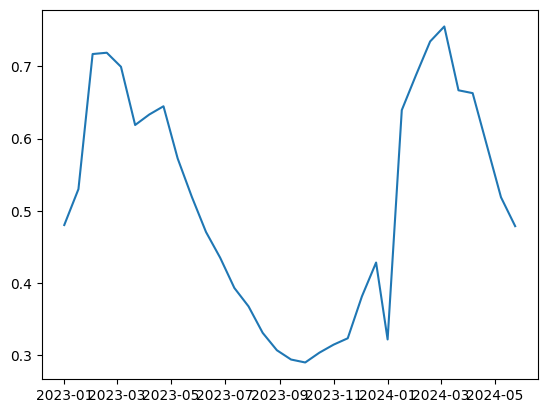

In [201]:
plt.plot(dt_arr, ndvi_mean_outside)

In [114]:
mean_in_region(ndvi_col.first())

In [154]:
mean_ndvi = ndvi_col.map(mean_in_region)

In [159]:
print(mean_ndvi.getString("NDVI"))

ee.String({
  "functionInvocationValue": {
    "functionName": "Element.getString",
    "arguments": {
      "object": {
        "functionInvocationValue": {
          "functionName": "Collection.map",
          "arguments": {
            "baseAlgorithm": {
              "functionDefinitionValue": {
                "argumentNames": [
                  "_MAPPING_VAR_0_0"
                ],
                "body": {
                  "functionInvocationValue": {
                    "functionName": "Image.reduceRegion",
                    "arguments": {
                      "geometry": {
                        "functionInvocationValue": {
                          "functionName": "Collection.geometry",
                          "arguments": {
                            "collection": {
                              "functionInvocationValue": {
                                "functionName": "Collection",
                                "arguments": {
                                  "

In [130]:
ndvi_col.flatten().toList(33)

EEException: The input collection must be a collection of collections, but the element with id 2023_01_01 was <Image<[NDVI]>>, which is not a collection.

In [47]:
np_arr_file = "/data/tapas/cnn_lstm/malawi/cnn_lstm_training/flattened_arrs/3D_nonstatic_v1_national_parks.npy"
all_arr_file = "/data/tapas/cnn_lstm/malawi/cnn_lstm_training/nonstatic/nonstatic_training_v0.npy"
np_arrs = np.load(np_arr_file)
all_arrs = np.load(all_arr_file)


In [97]:
del all_arrs

In [52]:
import matplotlib.pyplot as plt

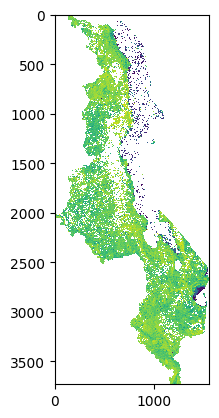

In [55]:
plt.imshow(all_arrs[0,:,:,0], interpolation="nearest")

In [65]:
np_arrs[0,:,0].shape

(362124,)

In [187]:
"/home/dualta/tapas/aiclimatise/transformer_v2/middle_malawi.geojson"

'/home/dualta/tapas/aiclimatise/transformer_v2/middle_malawi.geojson'